In [3]:
import os
import json
import time

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader

from dataset import NoisyLibriSpeechDataset, get_data_split_idxs
from train import train, evaluate, set_device
from display import play_audio, plot_loss, display_results
from models import FCAE, CDAE, UNet


# Set compute device
device = set_device(verbose=True)

# Data params
srate = 16000
data_root = 'data/noised_synth_babble'
libri_root = 'data/LibriSpeech/dev-clean'
seed = 1
batch_size=8

N = 2703
N = 5
test_size = .10
conv = True

# Create dataset splits
train_idxs, val_idxs, test_idxs = get_data_split_idxs(
    N, test_size=.10, seed=seed)

# Load training data
data_train = NoisyLibriSpeechDataset(
    data_root=data_root, libri_root=libri_root,
    include_idxs=train_idxs, test=False,
    conv=conv, seed=seed)
train_dl = DataLoader(
    data_train, batch_size=batch_size,
    num_workers=0, pin_memory=False)

# Load validation data
data_val = NoisyLibriSpeechDataset(
    data_root=data_root, libri_root=libri_root,
    include_idxs=val_idxs, test=False,
    conv=conv, seed=seed)
val_dl = DataLoader(
    data_val, batch_size=batch_size,
    num_workers=0, pin_memory=False)

# Load testing data
data_test = NoisyLibriSpeechDataset(
    data_root=data_root, libri_root=libri_root,
    include_idxs=test_idxs, test=True,
    conv=conv, seed=seed)

device:  cpu


## Fully-Connected Autoencoder

In [ ]:
# Model params
loss = nn.MSELoss()
epochs = 2
learning_rate = 0.01

# Create model and send to device
model = FCAE(
    data_train.target_shape,
    n_layers=4,
    z_dim=8).to(device)

# Train model
model, hist = train(
    device,
    model,
    train_dl,
    epochs=epochs,
    learning_rate=learning_rate,
    criterion=loss)

# Plot Loss
fig, ax = plt.subplots(figsize=(10, 5))
ax = plot_loss(ax, hist['losses'], 'MSE')
fig.show()

# Evaluate Model
fig, axes = evaluate(model, data_test)
fig.show()

## Convolutional Autoencoder

100%|####################################################| 1/1 [00:24<00:00, 24.36s/it, avg. loss=24.5, cur. loss=24.5]


Clean Signal


Noised Signal


Denoised Signal


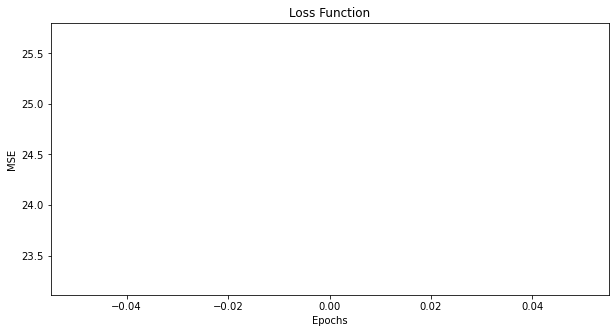

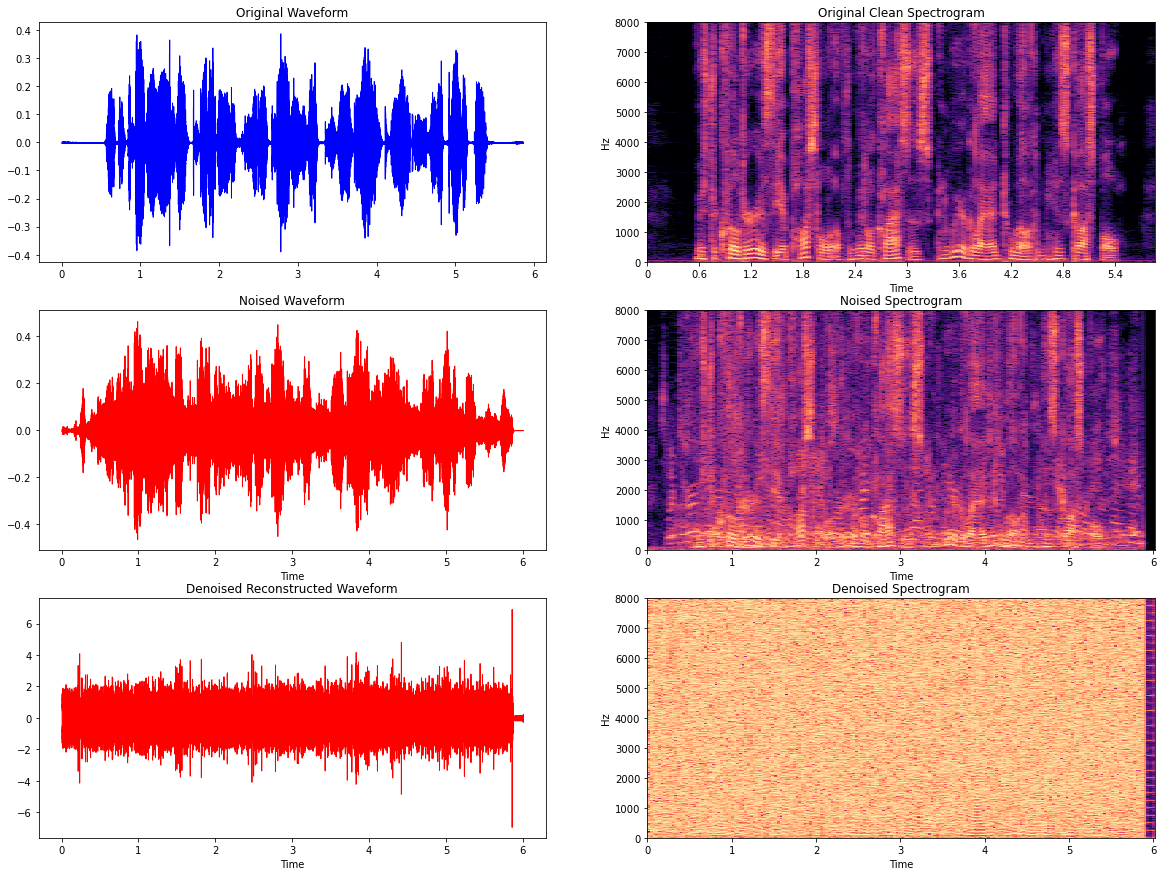

In [4]:
loss = nn.BCELoss()
epochs = 2
learning_rate = 0.01

model = CDAE(n_layers=4, z_dim=8, in_channels=1).to(device)
model, hist = train(
    device,
    model,
    train_dl,
    epochs=epochs, 
    learning_rate=learning_rate,
    criterion=loss)

# Plot Loss
fig, ax = plt.subplots(figsize=(10, 5))
ax = plot_loss(ax, hist['losses'], 'MSE')
fig.show()

# Evaluate Model
fig, axes = evaluate(model, data_test)
fig.show()

## U-Net

In [ ]:
loss = nn.BCELoss()
epochs = 1
learning_rate = 0.01

model = UNet(up_mode='upsample', in_channels=1, n_classes=1).to(device)
model, hist = train(
    model, train_dl,
    epochs=epochs, 
    learning_rate=learning_rate,
    criterion=loss)

fig, ax = plt.subplots(figsize=(10, 5))
ax = plot_loss(ax, hist['losses'], loss._get_name())
fig.show()